In [142]:
import os
from itertools import chain
import json

from datetime import datetime
import imagesize
import numpy as np
import cv2
 
def create_info(json_data):
    datetime_str = json_data['time']
    try:
        datetime_obj = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        year = datetime_obj.year
        date_created = datetime_obj.strftime('%Y/%m/%d')
    except ValueError:
        year = -1
        date_created = ""
        
    info = {
        "description": "Neurocle dataset",
        "url": "https://neuro-cle.com",
        "version": "1.0",
        "year": year,
        "contributor": "Research",
        "date_created": date_created
    }
    return info
 
def create_licenses(json_data):
    return []
 
def create_images(json_data, image_folder):
    label_type = json_data['label_type']
    assert label_type in ("reg", "box", "ocr"), f"레이블 타입은 reg, box, ocr 중 하나여야 합니다.: {label_type}"
    label_data = json_data['data']
 
    converted_images = []
    
    image_dims = {}

    for image_id, label in enumerate(label_data):
        filename = label['fileName']
        imagefile = os.path.join(image_folder, filename)

        if not os.path.isfile(imagefile):
            print(f"이미지 파일이 존재하지 않습니다: {imagefile}")
            continue

        width, height = imagesize.get(imagefile)
        
        converted_images.append({
            'license': -1,
            'file_name': filename,
            'coco_url': "",
            'height': height,
            'width': width,
            'date_captured': "",
            'flickr_url': "",
            'id': image_id
        })
        image_dims[image_id] = (height, width)

    return converted_images, image_dims
 
def convert_polyline_to_polygon(points, strokewidth, image_width, image_height):
    points = np.array(points, dtype=np.int32)
    canvas = np.zeros((image_height, image_width), dtype=np.uint8)
    canvas = cv2.polylines(canvas, [points], isClosed=False, color=255, thickness=strokewidth)
    contours, _ = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Assuming the largest contour is our desired polygon
    largest_contour = max(contours, key=cv2.contourArea)
    largest_contour = np.squeeze(largest_contour)
    polygon = []
    for x, y in largest_contour:
        polygon.extend([int(x), int(y)])
    return polygon
 
# def convert_ellipse_to_polygon(center_x, center_y, radiusx, radiusy, num_points = 100):
#     angle = 0  # No rotation
#     ellipse_points = cv2.ellipse2Poly((center_x, center_y), (radiusx, radiusy), angle, 0, 360, 360 // num_points)
#     polygon = np.array([(point[0], point[1]) for point in ellipse_points])
#     return polygon
 
def convert_rect_to_polygon(min_x, min_y, width, height):
    top_left = (min_x, min_y)
    top_right = (min_x + width, min_y)
    bottom_right = (min_x + width, min_y + height)
    bottom_left = (min_x, min_y + height)
    polygon = (top_left, top_right, bottom_right, bottom_left)
    return polygon
 
def polygon_area(polygon):
    reshaped_polygon = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
    return cv2.contourArea(reshaped_polygon)
 
def polygon_to_bbox(polygon):
    reshaped_polygon = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
    x, y, width, height = cv2.boundingRect(reshaped_polygon)
    return [x, y, width, height]
 
def create_categories(json_data):
    label_data = json_data['data']
    converted_categories = []
    category_map = {}
    for image_id, label in enumerate(label_data):
        for regionlabel in label['regionLabel']:
            classname = regionlabel['className']
            if classname not in category_map:
                category_map[classname] = len(category_map) + 1
 
                converted_categories.append({
                    'id': category_map[classname],
                    'name': classname,
                    'supercategory': classname
                })
 
    # create_annotations에서 classname으로 category_id를 찾기 위해 반환
    return converted_categories, category_map
 
def create_annotations(json_data, image_dims, category_map):
    label_type = json_data['label_type']
    assert label_type in ("reg", "box", "ocr"), f"레이블 타입은 reg, box, ocr 중 하나여야 합니다.: {label_type}"
    label_data = json_data['data']
 
    converted_anns = []
    ann_id = 0
    for image_id, label in enumerate(label_data):
        if image_id not in image_dims:
            continue # 이미지가 없는 경우
        
        image_height, image_width = image_dims[image_id]
 
        for regionlabel in label['regionLabel']:
            category_id = category_map[regionlabel['className']]
 
            if label_type == "reg":
                shape = regionlabel['type']
 
                if shape == "PolyLine":
                    points = regionlabel['points']
                    strokewidth = regionlabel['strokeWidth']
                    
                    polygon = convert_polyline_to_polygon(points, strokewidth, image_width, image_height)

                    if not polygon:
                        continue
                    
                elif shape == "Ellipse":
                    raise NotImplementedError
                    # x, y, radiusx, radiusy = regionlabel+['x'], regionlabel['y'], regionlabel['radiusX'], regionlabel['radiusY']
                    
                    # polygon = convert_ellipse_to_polygon(x, y, radiusx, radiusy)
 
                elif shape == "Rect":
                    raise NotImplementedError
                    # x, y, width, height = regionlabel['x'], regionlabel['y'], regionlabel['width'], regionlabel['height']
 
                    # polygon = convert_rect_to_polygon(x, y, width, height)
 
                elif shape == "PolyGon":
                    points = regionlabel['points']
                    polygon = list(chain.from_iterable(points))

 
            elif label_type in ("box", "ocr"):
                x, y, width, height = regionlabel['x'], regionlabel['y'], regionlabel['width'], regionlabel['height']
                polygon = convert_rect_to_polygon(x, y, width, height)
                polygon = list(chain.from_iterable(polygon))
                
            else:
                continue
 
            converted_anns.append({
                'id': ann_id,
                'category_id': category_id,
                'area': polygon_area(polygon), # area of segmentation mask
                'bbox': polygon_to_bbox(polygon), # [xmin, ymin, w, h]
                'image_id': image_id,
                'iscrowd': 0,
                'segmentation': [polygon,] # [[x1, y1, x2, y2, x3, y3...]]
            })
            ann_id += 1
 
    return converted_anns
 
 
def convert_neurot_to_coco(neurot_json_path, image_folder, output_json_path):
    json_data = json.load(open(neurot_json_path, "r"))
    
    info = create_info(json_data)
    licenses = create_licenses(json_data)
    images, image_ids = create_images(json_data, image_folder)
    categories, category_map = create_categories(json_data)
    annotations = create_annotations(json_data, image_ids, category_map)
    
    coco_data = {
        "info": info,
        "licenses": licenses,
        "images": images,
        "categories": categories,
        "annotations": annotations
    }
    
    if output_json_path:
        json.dump(coco_data, open(output_json_path, "w"), indent=4)
    
    return coco_data

In [143]:
json_path = "/datasets/conflearn/raw/공 초콜릿_Det/2. json 파일/choco-ball.json"
image_folder = "/datasets/conflearn/det/chocoball/images"
output_json_path = "/datasets/conflearn/det/chocoball/label.json"

In [144]:
neurot_anns = convert_neurot_to_coco(json_path, image_folder, output_json_path)

In [145]:
from torchvision.datasets import CocoDetection
coco = CocoDetection(image_folder, output_json_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [146]:
target

[{'id': 0,
  'category_id': 1,
  'image_id': 0,
  'iscrowd': 0,
  'area': 4692,
  'bbox': [220, 339, 68, 69]},
 {'id': 1,
  'category_id': 1,
  'image_id': 0,
  'iscrowd': 0,
  'area': 4692,
  'bbox': [66, 391, 68, 69]},
 {'id': 2,
  'category_id': 2,
  'image_id': 0,
  'iscrowd': 0,
  'area': 4692,
  'bbox': [159, 177, 68, 69]},
 {'id': 3,
  'category_id': 2,
  'image_id': 0,
  'iscrowd': 0,
  'area': 4692,
  'bbox': [286, 330, 68, 69]},
 {'id': 4,
  'category_id': 3,
  'image_id': 0,
  'iscrowd': 0,
  'area': 4692,
  'bbox': [25, 115, 68, 69]},
 {'id': 5,
  'category_id': 3,
  'image_id': 0,
  'iscrowd': 0,
  'area': 4692,
  'bbox': [46, 244, 68, 69]},
 {'id': 6,
  'category_id': 3,
  'image_id': 0,
  'iscrowd': 0,
  'area': 4830,
  'bbox': [25, 320, 70, 69]},
 {'id': 7,
  'category_id': 4,
  'image_id': 0,
  'iscrowd': 0,
  'area': 4830,
  'bbox': [58, 58, 70, 69]}]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


KeyboardInterrupt: 

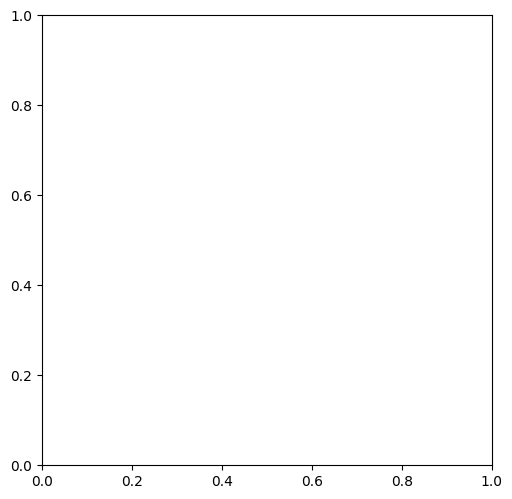

In [151]:
import matplotlib.pyplot as plt

for image_id, (image, target) in enumerate(coco):
    print(image_id)
    plt.imshow(image)
    coco.coco.showAnns(target, draw_bbox=False)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"/workspace/chocoball/{image_id}.png")
    plt.clf()
        